In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from math import sqrt
from sklearn.metrics import mean_squared_error
import warnings
#from statlearning import plot_feature_importance
import matplotlib.pyplot as plt

### read数据并合并

The first column in the data provides an identifier for each listing and is included to comply with the Kaggle format.  It should not be used as a predictor in the analysis.  The response variable, price, is the second column in the training dataset.  It gives the British pound sterling (GBP) price per night for each listing.  Variables security_deposit, cleaning_fee and extra_people are also measured in GPB and correspond to surcharges.  Variables latitude and longitude specify the geographic location of each property.  Several variables are Boolean, with the word true recorded as “t” and false recorded as “f”.  Some of the listings have missing values under some of the variables.  Note that, in many cases, a missing value means that the corresponding characteristic does not apply to that particular Airbnb listing.  This is information, rather than lack of information, and you could make use of this information in your analysis. 

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train['set'] = 1
df_test['set'] = 2
df_test['price'] = 0
df_all = pd.concat([df_train,df_test])
df_all.head()

,Id,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,cleaning_fee,experiences_offered,extra_people,...,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,room_type,security_deposit,set
0,1000,4,4.0,Real Bed,1.0,4.0,flexible,NaN,none,0,...,9.0,8.0,9.0,9.0,80.0,10.0,0.76,Private room,NaN,1
1,1001,4,2.0,Real Bed,2.0,2.0,flexible,NaN,none,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Entire home/apt,NaN,1
2,1002,2,1.0,Real Bed,0.0,0.0,moderate,25.0,none,9,...,10.0,10.0,10.0,10.0,97.0,10.0,1.15,Entire home/apt,500.0,1
3,1003,3,1.0,Real Bed,0.0,2.0,strict_14_with_grace_period,29.0,none,15,...,10.0,9.0,10.0,10.0,90.0,9.0,2.26,Private room,80.0,1
4,1004,5,2.0,Real Bed,3.0,3.0,flexible,150.0,none,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Entire home/apt,300.0,1


In [3]:
#缺失值
df_all.isnull().sum()

Id                                    0
accommodates                          0
bathrooms                             6
bed_type                              0
bedrooms                              2
beds                                  3
cancellation_policy                   0
cleaning_fee                        472
experiences_offered                   0
extra_people                          0
guests_included                       0
host_identity_verified                1
host_is_superhost                     1
host_listings_count                   1
host_response_rate                  617
host_response_time                  617
instant_bookable                      0
latitude                              0
longitude                             0
maximum_nights                        0
minimum_nights                        0
number_of_reviews                     0
price                                 0
property_type                         0
require_guest_phone_verification      0


### 填充方式1

In [4]:
for i in ['cleaning_fee','review_scores_accuracy','review_scores_checkin',
          'review_scores_cleanliness','review_scores_communication','review_scores_location',
         'review_scores_rating','review_scores_value','security_deposit','host_listings_count',
          'bathrooms','bedrooms','beds']:
    df_all[i] = df_all[i].apply(lambda x: float(df_all[i].mean()) if pd.isnull(x) else x)

for i in ['host_response_rate','reviews_per_month']:
    df_all[i] = df_all[i].apply(lambda x: 0 if pd.isnull(x) else x)
    
#处理test set中的那个缺失值，不能直接删掉
df_all['host_identity_verified'] = df_all['host_identity_verified'].apply(lambda x: 'f' if pd.isnull(x) else x)    
df_all['host_is_superhost'] = df_all['host_is_superhost'].apply(lambda x: 'f' if pd.isnull(x) else x)    
df_all['host_response_time'] = df_all['host_response_time'].apply(lambda x: 'no response' if pd.isnull(x) else x)

### Drop 列

### 方式2

In [5]:
df_clean = df_all.drop(['Id','experiences_offered','bedrooms'],axis = 1)

### 方式3

In [6]:
'''cols1 = ["review_scores_accuracy" , "review_scores_checkin", "review_scores_cleanliness", "review_scores_communication", 
         "review_scores_location", "review_scores_rating", "review_scores_value","reviews_per_month"]
for i in cols1:    
    df_notnull = df_all.loc[(df_all[i].notnull())]
    df_isnull =  df_all.loc[(df_all[i].isnull())]
    #用哪些列作为X
    X = df_notnull.values[:,1:5]
    Y = df_notnull[i]
#use RandomForestRegressor to train data
    rfr = RandomForestRegressor(n_estimators=1000,n_jobs=-1)
    rfr.fit(X,Y)
    pred_cf = rfr.predict(df_isnull.values[:,1:5]).round(1)
    df_all.loc[(df_all[i].isnull()),i] = pred_cf'''

'cols1 = ["review_scores_accuracy" , "review_scores_checkin", "review_scores_cleanliness", "review_scores_communication", \n         "review_scores_location", "review_scores_rating", "review_scores_value","reviews_per_month"]\nfor i in cols1:    \n    df_notnull = df_all.loc[(df_all[i].notnull())]\n    df_isnull =  df_all.loc[(df_all[i].isnull())]\n    #用哪些列作为X\n    X = df_notnull.values[:,1:5]\n    Y = df_notnull[i]\n#use RandomForestRegressor to train data\n    rfr = RandomForestRegressor(n_estimators=1000,n_jobs=-1)\n    rfr.fit(X,Y)\n    pred_cf = rfr.predict(df_isnull.values[:,1:5]).round(1)\n    df_all.loc[(df_all[i].isnull()),i] = pred_cf'

### dummy

In [7]:
df_clean = df_clean.replace({'flexible':5,'moderate':4,'strict_14_with_grace_period':3,
                             'super_strict_30':2,'super_strict_60':1})
df_clean_dm = pd.get_dummies(df_clean)

#分出train和test
df_clean_dm_train = df_clean_dm.loc[df_clean_dm['set'] == 1]
df_clean_dm_test = df_clean_dm.loc[df_clean_dm['set'] == 2]

### 删除异常值

In [8]:
df_clean_dm_train = df_clean_dm_train[-((df_clean_dm_train.security_deposit > 2000) |  (df_clean_dm_train.beds > 12)|(df_clean_dm_train.host_listings_count> 300))]
df_clean_dm_train.shape

(983, 67)

### 通过correlation选variable

In [9]:
correlation = df_clean_dm_train.corr()['price'].sort_values()
correlation_gd = correlation.loc[(correlation > 0.1)|(correlation < -0.1)]
#记得drop掉multicolinearity的predictor,比如beds和bedrooms

In [10]:

df_selected = df_clean_dm[correlation_gd.index].copy()
df_selected_test = df_clean_dm_test[correlation_gd.index].copy()
df_selected_train = df_clean_dm_train[correlation_gd.index].copy()
print(df_selected_train.shape)

(983, 18)


### EDA

In [11]:
descriptive = df_clean_dm_train.describe()
descriptive.loc['skew', :] = df_clean_dm_train.skew()
descriptive.loc['kurt', :] = df_clean_dm_train.kurt()
descriptive[['latitude','longitude']].round(3)

,latitude,longitude
count,983.000,983.000
mean,51.511,-0.122
std,0.029,0.067
min,51.443,-0.269
25%,51.490,-0.181
50%,51.514,-0.121
75%,51.534,-0.070
max,51.565,0.032
skew,-0.257,0.112
kurt,-0.765,-0.813


In [12]:
df_all

,Id,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,cleaning_fee,experiences_offered,extra_people,...,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,room_type,security_deposit,set
0,1000,4,4.0,Real Bed,1.0,4.0,flexible,43.657723,none,0,...,9.000000,8.000000,9.000000,9.000000,80.000000,10.000000,0.76,Private room,204.304124,1
1,1001,4,2.0,Real Bed,2.0,2.0,flexible,43.657723,none,0,...,9.625337,9.282345,9.640162,9.538098,92.472727,9.233468,0.00,Entire home/apt,204.304124,1
2,1002,2,1.0,Real Bed,0.0,0.0,moderate,25.000000,none,9,...,10.000000,10.000000,10.000000,10.000000,97.000000,10.000000,1.15,Entire home/apt,500.000000,1
3,1003,3,1.0,Real Bed,0.0,2.0,strict_14_with_grace_period,29.000000,none,15,...,10.000000,9.000000,10.000000,10.000000,90.000000,9.000000,2.26,Private room,80.000000,1
4,1004,5,2.0,Real Bed,3.0,3.0,flexible,150.000000,none,0,...,9.625337,9.282345,9.640162,9.538098,92.472727,9.233468,0.00,Entire home/apt,300.000000,1
5,1005,6,1.5,Real Bed,3.0,3.0,strict_14_with_grace_period,43.657723,none,10,...,9.625337,9.282345,9.640162,9.538098,92.472727,9.233468,0.00,Entire home/apt,200.000000,1
6,1006,1,1.0,Real Bed,1.0,1.0,flexible,10.000000,none,0,...,9.625337,9.282345,9.640162,9.538098,92.472727,9.233468,0.00,Private room,0.000000,1
7,1007,8,3.5,Real Bed,4.0,4.0,strict_14_with_grace_period,300.000000,none,0,...,10.000000,10.000000,10.000000,8.000000,80.000000,6.000000,0.05,Entire home/apt,495.000000,1
8,1008,2,1.0,Real Bed,1.0,1.0,strict_14_with_grace_period,35.000000,none,0,...,9.000000,10.000000,10.000000,10.000000,96.000000,10.000000,0.96,Entire home/apt,200.000000,1
9,1009,2,1.0,Real Bed,1.0,1.0,flexible,43.657723,none,0,...,9.625337,9.282345,9.640162,9.538098,92.472727,9.233468,0.00,Private room,204.304124,1


In [13]:
# from statlearning import plot_histogram

# fig, ax = plot_histogram(df_selected_train['price'])
# ax.set_title('Distribution plot for price')
# plt.savefig('distribution plot.png')
# plt.show()

In [14]:
# y_train_log = np.log(df_selected_train['price'])
# fig, ax = plot_histogram(y_train_log)
# ax.set_title('Log Distribution plot for Price')
# plt.savefig('log distribution plot.png')
# plt.show()

In [15]:
# from statlearning import plot_histograms

# plot_histograms(df_selected_train)
# plt.show()

ModuleNotFoundError: No module named 'statlearning'

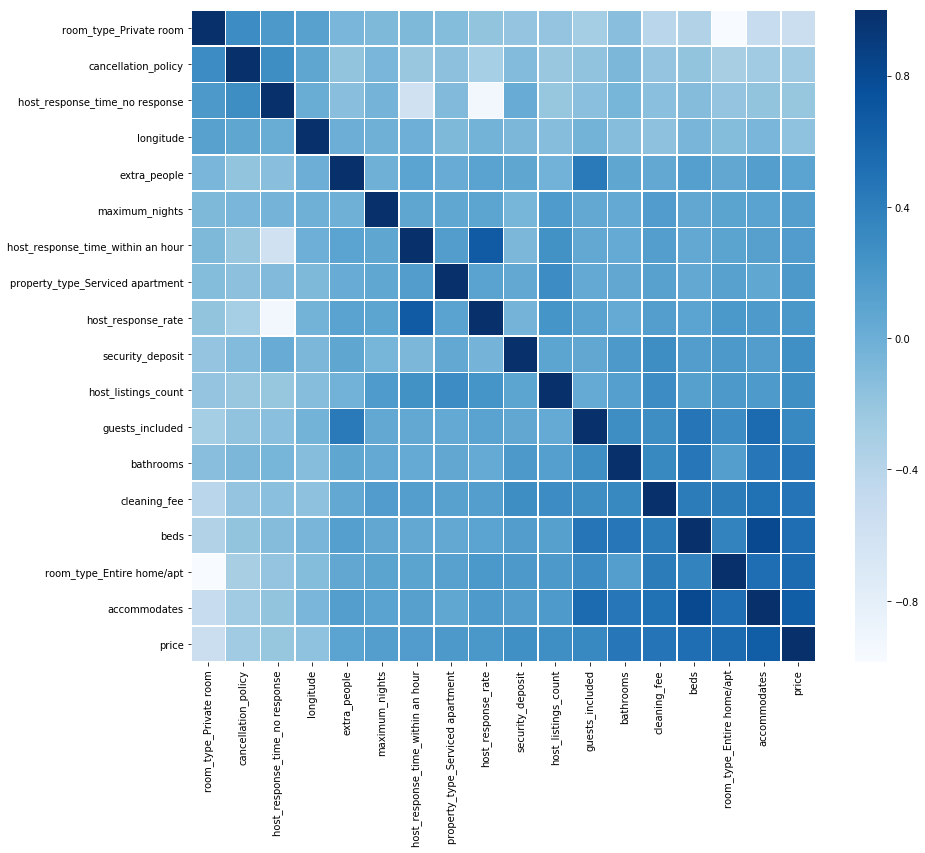

In [16]:
import seaborn as sns
df_cm = df_clean_dm_train[correlation_gd.index].corr()
plt.figure(figsize=(14,12))
sns.heatmap(df_cm,annot=False,cmap="Blues",fmt='.3g',linewidths=.5)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a238222e8>,
      dtype=object)

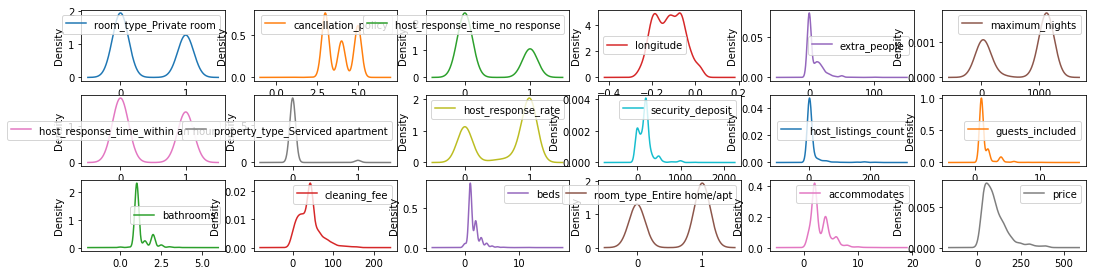

In [17]:
plt.rcParams['figure.figsize'] = (18, 6)

df_selected_train.plot(kind='density', layout=(4,6),subplots=True,sharex=False)

### 地理信息

You will pay special attention to and report on the relationship between the location and the price, both during the exploratory data analysis and during the model interpretation.  As part of feature engineering, you should create one new location-related variable by using the existing variables and, if you wish, external information. 

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import seaborn as sns

ax=None 
lllat=51.443
urlat=51.565
                  
lllon=-0.269
urlon=0.032
# This function is based on "Data Analytics Using Open-Source Tools" by Jeffrey Strickland
    
m = Basemap(ax=ax, projection='stere', 
            lon_0=(urlon + lllon)/2, lat_0=(urlat + lllat)/2, llcrnrlat=lllat, urcrnrlat=urlat,
            llcrnrlon=lllon, urcrnrlon=urlon,resolution="h")




# Plot Figure
fig, ax = plt.subplots(figsize=(9,9))
x, y = m(df_train['longitude'].as_matrix(), df_train['latitude'].as_matrix())

cm = plt.cm.get_cmap('RdYlBu')
#cmap = sns.diverging_palette(220, 10, as_cmap=True)
scatter = m.scatter(x,y, c=df_train['price'], edgecolors='none', cmap=cm, alpha=0.5)


m.drawrivers(color='blue')
m.drawcoastlines(color='purple')
ax.set_title('House Prices of AirBnb along Geography', fontsize=17, y=1.01, fontweight='bold')
ax.spines['bottom'].set_color('#DDDDDD')
ax.spines['top'].set_color('#DDDDDD')
ax.spines['right'].set_color('#DDDDDD')
ax.spines['left'].set_color('#DDDDDD')
plt.colorbar(scatter)
plt.tight_layout()
plt.show()

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

In [ ]:
from statlearning import plot_regressions
import seaborn as sns
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']

with sns.color_palette(crayon):
    plot_regressions(df_selected_train.iloc[:,0:17], df_selected_train.iloc[:,17])
    plt.show()

### Log transformation

In [ ]:
#粗暴全部log
df_selected_log1 = np.log1p(df_selected)

#挑选log
for i in ['price','accommodates']:
    df_selected[i] = np.log(df_selected[i])

df_selected_log1_train = df_selected_log1.loc[df_clean_dm['set'] == 1]
df_selected_log1_test = df_selected_log1.loc[df_clean_dm['set'] == 2]

In [ ]:
from statlearning import plot_histograms

plot_histograms(df_selected_log1_train)
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = (18, 6)

numerical_kaggle = df_selected_log1_train
numerical_kaggle.plot(kind='density', layout=(4,6),subplots=True,sharex=False)

In [ ]:
from statlearning import plot_regressions
import seaborn as sns
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']

with sns.color_palette(crayon):
    plot_regressions(df_selected_log1_train.iloc[:,0:17], df_selected_log1_train.iloc[:,17])
    plt.show()

### X和y

In [ ]:
X_train_log1 = df_selected_log1_train.iloc[:,0:17]
y_train_log1 = df_selected_log1_train['price']

X_test_log1 = df_selected_log1_test.iloc[:,0:17]

### PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train_log1)

# The explained variance of each variable in isolation
print(pca.explained_variance_ratio_)
# Cummulative variance
cum_var = np.cumsum(pca.explained_variance_ratio_) * 100
print(cum_var)

In [ ]:
plt.figure(figsize=(8,4))

plt.plot(np.arange(1, 18), cum_var, marker = "o")

plt.xlabel("Number of Components")
plt.ylabel("Variance")

plt.title("Scree Plot (Number of Components vs Variance)")

plt.savefig("scree plot(number of components).png")
plt.show()

In [ ]:
difference = np.diff(pca.explained_variance_ratio_)

plt.plot(pca.explained_variance_)

plt.show()

In [ ]:
first_component_weights = pd.DataFrame({'Feature': X_train_log1.columns, 'Weight': pca.components_[0]})

first_component_weights = first_component_weights.sort_values('Weight')

test = first_component_weights.reset_index(drop = True)

first_component_weights = first_component_weights.reset_index(drop=True)

plt.bar(np.arange(len(first_component_weights)), first_component_weights['Weight'])

# Xtick position, label, rotation and alignment
plt.xticks(np.arange(len(first_component_weights)), first_component_weights['Feature'],
              rotation = 30, horizontalalignment = "right")
plt.tight_layout()
plt.savefig("pca.png")
plt.show()

### Standardise

In [ ]:
#方法一
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train_log1)
scaler.fit(X_test_log1)

X_train_log1_scaled = scaler.transform(X_train_log1)
X_test_log1_scaled = scaler.transform(X_test_log1)

#方法二
X_train_log1_scale = X_train_log1.copy()
X_test_log1_scale = X_test_log1.copy()
for i in range(X_train_log1.shape[1]):
    X_train_log1_scale.iloc[:,i] = (X_train_log1.iloc[:,i] - X_train_log1.iloc[:,i].mean()) / X_train_log1.iloc[:,i].std()
    X_test_log1_scale.iloc[:,i] = (X_test_log1.iloc[:,i] - X_test_log1.iloc[:,i].mean()) / X_test_log1.iloc[:,i].std()


### OLS

In the methodology section you will discuss two of the five models in detail (the other three do not need to be discussed).  One of these two models will be your final model.  Also, one of these two models should be an interpretable model (e.g. OLS, subset selection, Lasso, Ridge, Elastic net, a single regression tree), and the second one should be a more advanced model (bagging, random forests, boosting, or a model that contains one of these three as a part).

In [ ]:
from sklearn.linear_model import LinearRegression
ols_model = LinearRegression(fit_intercept = True)
ols_model.fit(X_train_log1_scale, y_train_log1 )

In [ ]:
import statsmodels.api as sm

ols_sm_model = sm.OLS(y_train_log1,sm.add_constant(X_train_log1_scale)).fit()
print(ols_sm_model.summary())

In [ ]:
import seaborn as sns

fig, ax= plt.subplots()
sns.regplot(ols_sm_model.fittedvalues, ols_sm_model.resid)
ax.set_ylabel('Residuals')
ax.set_xlabel('Fitted values')
sns.despine()
plt.savefig("residual.png")
plt.show()

### RMSE1

In [ ]:
from sklearn.model_selection import cross_validate
ols_scores = cross_validate(ols_model,X_train_log1_scale, y_train_log1, cv=5,scoring=('r2', 'neg_mean_squared_error'),return_train_score=True)
rmse = np.sqrt(np.mean(-ols_scores['test_neg_mean_squared_error']))

print(rmse)

### RMSE 2

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import mean_squared_error

predicted = cross_val_predict(ols_model,X_train_log1, y_train_log1, cv=5)
original_rmse =  np.sqrt(mean_squared_error(np.exp(y_train_log1)-1, np.exp(predicted)-1))
print(original_rmse)
log1_rmse = np.sqrt(mean_squared_error(y_train_log1, predicted))
print(log1_rmse)

### RMSE 3

In [ ]:
from statlearning import rmse
predicted = cross_val_predict(ols_model,X_train_log1, y_train_log1, cv=5)
rmse(y_train_log1,predicted)[0]

### Ridge

In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline

alphas = list(np.logspace(-15,15,151, base=2))
ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('estimator', RidgeCV(alphas=alphas, cv=5)),
])

ridge.fit(X_train_log1, y_train_log1)

In [ ]:
from statlearning import plot_coefficients
plot_coefficients(ridge._final_estimator,X_train_log1.columns)
plt.show()

### Lasso

In [ ]:
from sklearn.linear_model import LassoCV

lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('estimator', LassoCV(cv=5)),
])

lasso.fit(X_train_log1, y_train_log1)

from statlearning import plot_coefficients

plot_coefficients(lasso._final_estimator,X_train_log1.columns)
plt.savefig("lasso.png")
plt.show()

### Elastic net

In [ ]:
from sklearn.linear_model import ElasticNetCV

enet = Pipeline([
    ('scaler', StandardScaler()),
    ('estimator', ElasticNetCV(l1_ratio=[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 0.99], cv=5, n_alphas=200)),
])

enet.fit(X_train_log1, y_train_log1)

plot_coefficients(enet._final_estimator,X_train_log1.columns)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
columns2=['RMSE']
rows2=['OLS_pca','Ridge_pca', 'Lasso_pca', 'Elastic Net_pca']
results2=pd.DataFrame(0.0, columns=columns2, index=rows2) 
methods2=[ols_model, ridge, lasso, enet]

for i, method in enumerate(methods2):
    y_pred_pca=np.exp(method.predict(X_train_log1))
    results2.iloc[i,0] = np.sqrt(mean_squared_error(y_train_log1, y_pred_pca))
    

results2.round(3)

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV

dt_model = DecisionTreeRegressor(min_samples_leaf=5)

tuning_parameters = {
    'min_samples_leaf': [1,5,10,20],
    'max_depth': np.arange(1,30),
}

tree = RandomizedSearchCV(dt_model, tuning_parameters, n_iter=20, cv=5, return_train_score=False)
tree.fit(X_train_log1, y_train_log1)

print('Best parameters:', tree.best_params_)

### Bagging
##### 就是从我们的训练集里面采集固定个数的样本，但是每采集一个样本后，都将样本放回。也就是说，之前采集到的样本在放回后有可能继续被采集到。对于我们的Bagging算法，一般会随机采集和训练集样本数m一样个数的样本。这样得到的采样集和训练集样本的个数相同，但是样本内容不同。如果我们对有m个样本训练集做T次的随机采样，则由于随机性，T个采样集各不相同。
##### 对于回归问题，通常使用简单平均法，对T个弱学习器得到的回归结果进行算术平均得到最终的模型输出。

In [ ]:
from sklearn.ensemble import BaggingRegressor
bag_model = BaggingRegressor(n_estimators=1000, random_state=1)
bag_model.fit(X_train_log1, y_train_log1)

### Random Foreast
##### 在使用决策树的基础上，RF对决策树的建立做了改进，对于普通的决策树，我们会在节点上所有的n个样本特征中选择一个最优的特征来做决策树的左右子树划分，但是RF通过随机选择节点上的一部分样本特征，这个数字小于n，假设为k，然后在这些随机选择的k个样本特征中，选择一个最优的特征来做决策树的左右子树划分。

In [ ]:
%%time

rf_model = RandomForestRegressor(n_estimators=1000)

tuning_parameters = {
    'min_samples_leaf': [1,5, 10, 20, 50],
    'max_features': np.arange(1, len(X_train_log1.columns)+1),
}

rf_search = RandomizedSearchCV(rf_model, tuning_parameters, cv = 10, n_iter= 16, return_train_score=False, n_jobs=4,
                              random_state = 20)
rf_search.fit(X_train_log1, y_train_log1)

rf = rf_search.best_estimator_

print('Best parameters found by randomised search:', rf_search.best_params_, '\n')

### Gradient Boosting

###### Bagging和Boosting的区别：

1）样本选择上：

Bagging：训练集是在原始集中有放回选取的，从原始集中选出的各轮训练集之间是独立的。

Boosting：每一轮的训练集不变，只是训练集中每个样例在分类器中的权重发生变化。而权值是根据上一轮的分类结果进行调整。

2）样例权重：

Bagging：使用均匀取样，每个样例的权重相等

Boosting：根据错误率不断调整样例的权值，错误率越大则权重越大。

3）预测函数：

Bagging：所有预测函数的权重相等。

Boosting：每个弱分类器都有相应的权重，对于分类误差小的分类器会有更大的权重。

4）并行计算：

Bagging：各个预测函数可以并行生成

Boosting：各个预测函数只能顺序生成，因为后一个模型参数需要前一轮模型的结果。

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
gb_model = GradientBoostingRegressor()

tuning_parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators' : [250, 500, 750, 1000, 1500],
    'max_depth' : [2 ,3, 4],
    'subsample' : [0.6, 0.8, 1.0]
}

# Using GridSearchCV would be too slow. Increase the number of iterations to explore more hyperparameter combinations.
gb_search = RandomizedSearchCV(gb_model, tuning_parameters, n_iter = 20, cv = 10, return_train_score=False, n_jobs=4)
gb_search.fit(X_train_log1, y_train_log1)

print('Best parameters found by randomised search:', gb_search.best_params_, '\n')

In [ ]:
gb = GradientBoostingRegressor(learning_rate= 0.05, max_depth = 4, n_estimators= 750, subsample = 1.0)
gb.fit(X_train_log1, y_train_log1)

In [ ]:
gb_search.best_estimator_

In [ ]:
from statlearning import plot_feature_importance

plot_feature_importance(gb_search.best_estimator_, X_train_log1.columns)
plt.savefig("boosting.png")
plt.show()

### Xgboost

conda config --add channels conda-forge

conda install py-xgboost

conda install lightgbm

conda install mlxtend

In [ ]:
%%time
import xgboost as xgb

xgb_model = xgb.XGBRegressor()

tuning_parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators' : [250, 500, 750, 1000, 1500],
    'max_depth' : [2, 3, 4],
    'subsample' : [0.6, 0.8, 1.0],
}

xgb_search = RandomizedSearchCV(xgb_model, tuning_parameters, n_iter = 16, cv = 5, return_train_score=False, n_jobs=4,
                              random_state = 20)
xgb_search.fit(X_train_log1, y_train_log1)

xbst = xgb_search.best_estimator_


print('Best parameters found by randomised search:', xgb_search.best_params_, '\n')

In [ ]:
plot_feature_importance(xbst, labels=X_train_log1.columns)
plt.show()

In [ ]:
%%time

dtrain = xgb.DMatrix(X_train_log1, y_train_log1) # we need to convert the data to the format required by xgboost
#dtest  = xgb.DMatrix(X_test)

param = {
    'max_depth': 2, 
    'learning_rate': 0.1, 
    'subsample': 0.8,
    'silent' : 0, 
    'objective':'reg:linear',  
     }

cv = xgb.cv(param, dtrain, num_boost_round = 1500, nfold=10, early_stopping_rounds=50)

print(f'Selected number of boosting iterations: {cv.shape[0]}')
print(f'RMSE (CV): {cv.iloc[-1,0]:.4f}')

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(cv.iloc[:,0])
ax.set_ylabel('Cross-validation RMSE')
ax.set_xlabel('Boosting iterations')
sns.despine()
plt.show()

In [ ]:
columns=['Test RMSE']
rows=['OLS', 'Lasso', 'Ridge', 'Elastic Net', 'Tree', 'Bagged Trees', 'Random Forest', 'SKLearn Boost']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[ols_model, lasso, ridge, enet, tree,  rf, gb, xbst]

for i, method in enumerate(methods):
    y_pred3=np.exp(method.predict(X_train_log1))
        
    results.iloc[i,0] = np.sqrt(mean_squared_error(y_train_log1, y_pred3))


results.round(3)

### Submit

In [ ]:
rf_output = rf_search.predict(X_test_log1.values)
test_output = df_test.copy()
test_output['price'] = rf_output
test_output[['Id','price']].to_csv('test1.csv',index = None)

In [ ]:
pred_ols = ols_model.predict(X_test_log1)
#一定要非常注意pred要转换回去
submission = pd.DataFrame(np.c_[X_test_log1.index,np.exp(pred_stack)-1], columns=['Id', 'price'])
submission['Id'] = submission['Id'].astype(int)
submission.to_csv('kaggle_submission.csv',  index=False)

In [ ]:
pred_stack.shape